# Hexike Basis and Rotations
Below we go through a script for generating rotated and sheered basis over hexagonal apertures. Note `dLux` provides better tools for working with the James Webb Space Telecope primary aperture.

In [1]:
from layers import *
from matplotlib import pyplot

First we create the basis class with nil values for the rotations and sheers. As per the docstring `rmax` indicates the proportion of the pixel grid that we want to be covered by the aperture. 

Similarly `x` and `y` are proportional movements. Think of the question what proportion of the pixel grid do I want to move the basis. This is going to change in future versions where all user inputs will be in phyiscal units. 

In [2]:
jwst = JWSTPrimaryAperture(1008)

In [3]:
JWST_PRIMARY_SEGMENTS[6][1][:, 1].max()

DeviceArray(3.279674, dtype=float64)

In [4]:
B1 = JWSTPrimaryApertureSegment("B1-7", 1008, jwst.pixel_scale)

In [5]:
vertices = B1._load("B1-7")

In [6]:
vertices

DeviceArray([[ 0.38101 ,  3.279674],
             [ 0.758826,  2.631791],
             [ 0.38101 ,  1.98402 ],
             [-0.38101 ,  1.98402 ],
             [-0.758826,  2.631791],
             [-0.38101 ,  3.279674]], dtype=float64)

In [7]:
x, y, phi = B1._vertices(vertices)

In [8]:
rho, theta = B1._coordinates(phi[0])

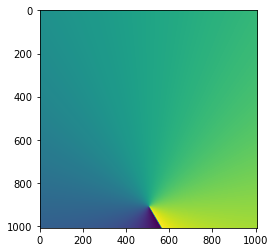

In [18]:
pyplot.imshow(theta[0])

In [10]:
aperture = B1._aperture()

In [30]:
edges = B1._edges(x, y, rho, theta)

In [31]:
wedges = B1._wedges(phi, theta)

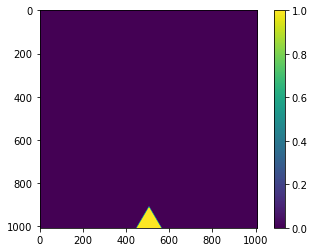

In [35]:
pyplot.imshow((edges[0] & wedges[0]))
pyplot.colorbar()

The `__call__` dunder method of the `HexagonalBasis` class is inherited from `Basis` and instantly applies the phase difference to a `Wavefront`. To independently get the basis we use the private `_basis` method. 

Compile time is lengthy and runtime is not ideal. To make the code `jit`-able and `grad`-able sacrifices were made regarding performance. Hopefully this will be fixed in future versions. 

In [14]:
aperture = jwst._aperture()

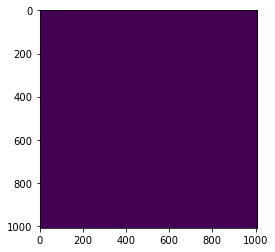

In [15]:
pyplot.imshow(aperture)

In [16]:
basis = hex_basis._basis()

figure = pyplot.figure(figsize=(15, 12))
for i in range(9):
    pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(basis[i])
    pyplot.colorbar()

NameError: name 'hex_basis' is not defined

Now is where the magic happens. We may want to move the Basis vectors around and shrink them so that we may stack our basis into a 4 dimensional tensor with the shape `(nhex, nterms, npix, npix)` and multiply by a `(nterms, nhex)`  matrix of coefficients. 

We can either re-use the same instance or instantiate many. The advantage to re-use is that the `_basis` method is compiled. However, if this script is not dynamic and time is not an issue then multiple instances will save you time. 

Let's generate a very crude model of the JWST primary aperture basis. There are better ones currently in development.

In [ ]:
basis = []
for i in range(6):
    basis.append(hex_basis\
        .set_magnification(0.2)\
        .set_x_offset(.35 * np.cos(i * np.pi / 3 + np.pi / 6))\
        .set_y_offset(.35 * np.sin(i * np.pi / 3 + np.pi / 6))\
        ._basis())

Unfortunately, you will need to pull out a piece of paper and do some derivations to work out the positions of the centres in normlised units. As I said this is getting removed in the newer version. 

Note that the magnification doubles as the distance from the centre of the hexagon to one of the vertices. 

In [ ]:
X = [0.6, 0.6, 0.3, 0., -0.3, -0.6, -0.6, -0.6, -0.3, 0.0, 0.3, 0.6]
Y = [0., 0.35, 0.525, 0.7, 0.525, 0.35, 0, -0.35, -0.525, -0.7, -0.525, -0.35]

In [ ]:
for i in range(12):
    basis.append(hex_basis\
        .set_magnification(0.2)\
        .set_x_offset(X[i])\
        .set_y_offset(Y[i])\
        ._basis())

In [ ]:
b = np.stack(basis)

In [ ]:
b = b.sum(axis=0)

In [ ]:
figure = pyplot.figure(figsize=(15, 12))
for i in range(9):
    pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(b[i])
    pyplot.colorbar()